<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/ML_T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tarea 1. Aprendizaje máquina.**

Caso general. Sean $\{(x_i,y_i)\}_{i=1}^{n}$ datos dados. Supongamos $m<<n$,  y $\{x_i\}_{i=1}^{m}\subset \{x_i\}_{i=1}^{n}$ una muestra aleatoria.

Definimos nuestra funcion de pérdida $$L(\alpha,\sigma)=||Y-\Phi_\sigma \cdot \alpha||^2_2$$

Donde $(\Phi_\sigma)_{i,j}=(\Phi_\sigma)_{i,j}(\sigma_j,x_j,x_i)$, para $i=1,2\ldots,n$, $j=1,2,\ldots,m$

Es decir, $\Phi_\sigma \cdot \alpha : \mathbb{R}^m\longrightarrow \mathbb{R}^n$.

Procederemos resolviendo 2 problemas de manera alternada.

**Problema 1**. Supongamos $\sigma$ conocida y constante. 
En tal caso, el problema $$argmin_{\alpha} L(\alpha)=||Y-\Phi_\sigma \cdot \alpha||^2_2$$
tiene solución trivial dada por $$\nabla_\alpha (L(\alpha))=0$$
$$\Phi_\sigma^t (Y-\Phi_\sigma\alpha)=0$$
$$\alpha=(\Phi_\sigma ^t\Phi_\sigma)^{-1}\Phi_\sigma^t Y$$

**Problema 2**. Supongamos $\alpha$ conocida y constante.
En tal caso, nos interesa resolver el problema $$argmin_{\sigma} L(\sigma)=||Y-\Phi_\sigma \cdot \alpha||^2_2$$
Aquí, para calcular el gradiente, primero notemos que 
$\Phi_\sigma\cdot \alpha =\Phi_\sigma(\sigma)\cdot \alpha$, es decir, es una función de $\sigma$. Si denotamos por $J_\sigma$ a la Jacobiana de esta función, tenemos 
$$\nabla_\sigma (L(\sigma))=(J_\sigma)^t (Y-\Phi_\sigma \cdot \alpha)$$

Obviamos las cuentitas, pero para resolver el problema, utilizaremos algún método de gradiente descendiente. Digamos, el de Nesterov.


De esta manera, podemos intercalar los problemas y obtener sucesiones $\alpha_k$, $\sigma_k$ de la siguiente manera.

**Algoritmo:**
Supongamos $\alpha_0$, $\sigma_0$ dadas por el usuario.

1.- Actualizar $\alpha_{k+1}$ como la solución del problema 1.

2.- Actualizar $\alpha_{k+1}$ como la solución del problema 2.

3.- Repetir hasta que se satisfaga un criterio de paro.

# Caso particular 1. Implementación y ejemplo.

Supongamos que deseamos minimizar $$\sum\limits_{i=1}^{n}(y_i-\sum\limits_{j=1}^{m}\alpha_j \cdot \underbrace{exp(-\frac{(x_i-\mu_j)^2}{2\sigma_j^2})}_{\phi_\sigma})^2$$.

Donde $\mu_j$ son centros elegidos de los datos aleatorios, pero fijos. 



In [1]:
import numpy as np
import matplotlib.pyplot as plt

Consideraremos el método de gradiente de descenso de Nesterov para aproximar la solución del problema no lineal

In [6]:
def GD_N(theta,alpha,eta,nIter, grad,stop_crit=10**(-4)):#GD Nesterov.
    p     = np.zeros(theta.shape)
    Theta=[theta]
    for t in range(nIter):
        pre_theta = theta - 2.0*alpha*p
        g = grad(pre_theta)
        p = 0.5*(g + eta*p)
        if(np.linalg.norm(g)<stop_crit):
            if(t==0):
                print("No hizo nada\n")
            break
        theta = theta - alpha*p
        Theta.append(theta)
    #print("Iteraciones: ",t)
    return Theta[-1]

Por comodidad, generamos los datos a partir de una función conocida $f(x)=log(x)$ y agregamos un ruido Gaussiano $N(0,s^2)$.
Además, seleccionamos de manera aleatoria $m$ puntos para que sean los centros $\mu_j$ de las funciones de base readial.

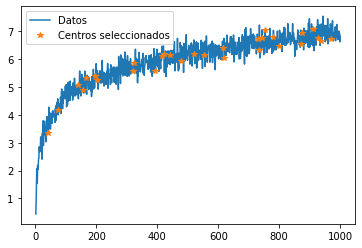

In [ ]:
#Datos-----------------
np.random.seed(0)
n=1000
x=np.linspace(1,n,n)
y=np.log(x)+np.random.normal(0,.25,size=len(x))
from numpy.random import default_rng
m=30
x_m=np.sort(default_rng().choice(np.arange(0, len(x)), size=m, replace=False))
y_m=y[x_m]
plt.plot(x,y,label='Datos')
plt.plot(x_m,y_m,'*',label='Centros seleccionados')
plt.legend()
plt.show()
#-----------------------------

Para resolver el problema 1, (Dada $\sigma$, encontrar la solución exacta de el vector $\alpha$), definimos la matriz $\Phi_\sigma$.

In [ ]:
def matriz_phi_sigma(sigma):#Matriz Phi
    M=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            M[i,j] = np.exp(-((x[i] -x_m[j])**2)/(2*(sigma[j])**2))
    return M

Simplemente actualizamos 
$\alpha=(\Phi_\sigma ^t\Phi_\sigma)^{-1}\Phi_\sigma^t Y$



In [7]:
def solve_for_alphas(M,y):#Resolver para alphas.
    return np.dot(np.dot(np.linalg.inv(np.dot(M.T,M)),M.T),y)

Para resolver el problema 2 (Dado $\alpha$, aproximar la solución para el vector $\sigma$), debemos definir el gradiente respecto a $\sigma$, para ello, es necesario la matriz Jacobiana (respecto a $\sigma$) de $\Phi_\sigma\cdot \alpha$.

In [8]:
def phi(s,x,x_j):#Funciones reales. phi_{i,j}"
    return np.exp(-(1/(2*s**2))*(x-x_j)**2)

In [ ]:
def J_sigma_phi(sigma,alpha):#Jacobiana de la transformacion Phi*alpha como funcion de sigma.
    J=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            J[i][j]=alpha[j]*(phi(s=sigma[j],x=x[i],x_j=x_m[j]))*((x[i]-x_m[j])**2/sigma[j]**3)
    return J

Como la función gradiente depende de los vectores $\alpha$ y $\sigma$, la definimos dentro de una rutina definida por el Algoritmo descrito.

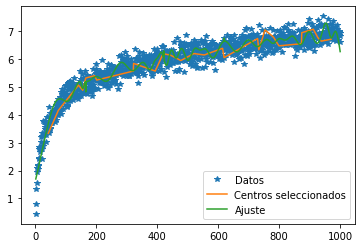

In [ ]:
def F_ajuste(sigma,alpha,z):#Funcion de ajuste dado alpha, sigma, x. Con x real
    sum=0
    for j in range(m):
        sum+=alpha[j]*np.exp(-(1/(2*sigma[j]**2))*(z-x_m[j])**2)
    return sum
def rutina(n,sigma_0,alpha_0,alpha):#Repetir los ajustes alternados.
    for r in range(n): 
        alpha_0=solve_for_alphas(M=matriz_phi_sigma(sigma_0),y=y)
        def grad_alpha(sigma):
            return np.dot(-J_sigma_phi(sigma=sigma,alpha=alpha_0).T,(y-np.dot(matriz_phi_sigma(sigma=sigma),alpha_0)))
        sigma_0=GD_N(theta=sigma_0,alpha=alpha,eta=0.9,nIter=k, grad=grad_alpha,stop_crit=10**(-6))
    def F_ajuste_a_s(W):
       R=[]
       for w in W:
           R.append(F_ajuste(sigma=sigma_0,alpha=alpha_0,z=w))
       return np.array(R)
    plt.plot(x,y,'*',label='Datos')
    plt.plot(x_m,y_m,label='Centros seleccionados')
    plt.plot(x,F_ajuste_a_s(x),label='Ajuste')
    plt.legend()
    plt.show()
    return alpha_0,sigma_0
#Condiciones iniciales-------------
sigma_0=np.random.normal(3,0.5,size=m)
alpha_0=np.repeat(1,m)
#-----------------
k=10#Numero de iteraciones para el gradiente descendente.
alpha_opt,sigma_opt=rutina(30,sigma_0=sigma_0,alpha_0=alpha_0,alpha=0.1)

# Caso particular 2. Implementación y ejemplo.

Supongamos que tenemos acceso a observaciones de la derivada de alguna función desconocida. En tal caso, si conseguimos un ajuste a estos datos, después de integrar nuestra función de ajuste, podríamos ser capaces de aproximar a la función original, la cual es desconocida. En este caso, deseamos minimizar $$\sum\limits_{i=1}^{n}(y_i-\sum\limits_{j=1}^{m}\alpha_j \cdot \underbrace{exp(-\frac{(x_i-\mu_j)^2}{2\sigma_j^2})\cdot (-\frac{x_i-\mu_j}{\sigma_j^2})}_{\dot{\phi}_\sigma})^2$$.

Donde $\mu_j$ son centros elegidos de los datos aleatorios, pero fijos. En este caso, nuestras funciones que se usarán para la combinación lineal, son $\frac{\partial}{\partial x} \phi_\sigma (x)$.

De nuevo, por comodidad generaremos los datos a utilizar. Esta vez, sin embargo, consideraremos datos menos ruidosos. (¿por qué? Notamos que las funciones de ajuste son menos nobles, en particular, no acotadas.)

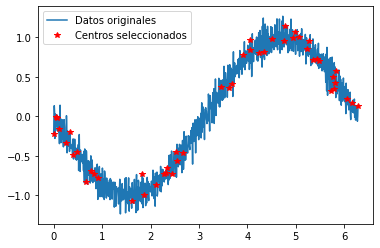

In [81]:
#Datos---------------------Los generamos por comodidad.
np.random.seed(0)
n=1000
x=np.linspace(0,2*np.pi,n)
y=np.cos(x)+np.random.normal(0,0.001,size=len(x))
from numpy.random import default_rng
m=50
x_m2=[0]*m
x_m2[0]=0#Fijamos los extremos como centros.
x_m2[-1]=len(x)-1
x_m2[1:-1]=np.sort(default_rng().choice(np.arange(1, len(x)-1), size=m-2, replace=False))
x_m=x[x_m2]
#Diferencias finitas.----------------
y_p=np.zeros(n)
y_p[0]=(y[1]-y[0])
y_p[-1]=y[-1]-y[-2]
y_p[1:-2]=(y[2:-1]-y[0:-3])/2
y_p=y_p*n/(2*np.pi)
plt.plot(x,y_p,label='Datos originales')
plt.plot(x_m,y_p[x_m2],"r*",label='Centros seleccionados')
plt.legend()
plt.show()
#
#-------------------------------


Le vamos a ajustar nuestra combinación lineal a los datos $Y_p$.
Para ello, igual que antes, definiremos la matriz $\dot{\Phi}_\sigma $.

In [82]:
#Matriz Phi_prima--------------------------------
def matriz_phi_x_sigma(sigma):
    M=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            M[i,j] = phi(s=sigma[j],x=x[i],x_j=x_m[j])*(-(x[i] -x_m[j])/(sigma[j]**2))#phi_prima
            #
    return np.array(M)
#---------------------------------

Notemos que la phi es la misma que en el ejemplo anterior. Una funcion de base radial. Además, la función que resuelve el problema 1, es la misma, sólo especificando que ahora se resuelve para $Y_p$.

Ahora, definimos la función necesaria para calcular la matriz Jacobiana (respecto a $\sigma$) de la función $\dot{\Phi}_\sigma \cdot \alpha$.

In [83]:
def J_sigma_phi_x(sigma,alpha):#Jacobiana de la transformacion Phi*alpha como funcion de sigma.
    J=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            J[i][j]=alpha[j]*(phi(s=sigma[j],x=x[i],x_j=x_m[j])*(((x[i]-x_m[j])**2)/sigma[j]**3)*(-(x[i]-x_m[j])/sigma[j]**2)+phi(s=sigma[j],x=x[i],x_j=x_m[j])*(2*(x[i]-x_m[j])/sigma[j]**3))
    return J
#-------------------------------------------

Consideraremos 2 tamaños de paso sobre la misma rutina porque notamos que el gradiente es muy sensible a este tamaño de paso. Entonces buscamos reducirlo conforme avanzamos en las iteraciones.

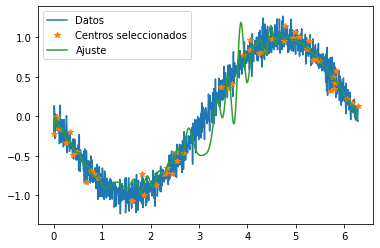

In [90]:
#Funcion de ajuste dado alpha, sigma, x. Con x real--------------------
def F_p_ajuste(sigma,alpha,z):
    sum=0
    for j in range(m):
        sum+=alpha[j]*phi(s=sigma[j],x=z,x_j=x_m[j])*(-(z -x_m[j])/(sigma[j]**2))
    return sum
def rutina_prima(nIter,sigma_0,alpha_0,alpha,stop=10**(-2)):#Repetir los ajustes alternados.
    error=10
    for r in range(nIter): 
        def grad_alpha(sigma):
            return np.dot(-J_sigma_phi_x(sigma=sigma,alpha=alpha_0).T,(y_p-np.dot(matriz_phi_x_sigma(sigma=sigma),alpha_0)))
        alpha_0=solve_for_alphas(M=matriz_phi_x_sigma(sigma_0),y=y_p)
        sigma_0=GD_N(theta=sigma_0,alpha=alpha,eta=0.9,nIter=k, grad=grad_alpha,stop_crit=10**(-6))# Llamar a Nesterov 15 veces
        error=np.linalg.norm(y_p-np.dot(matriz_phi_x_sigma(sigma=sigma_0),alpha_0))
        if(error<=stop):
            print("Criterio de paro")
            break;
    return alpha_0,sigma_0
#----------------------------------------
#Condiciones iniciales------------
np.random.seed(0)
sigma_0=np.random.normal(0.1,0.01,size=m)#A ojo
alpha_0=np.repeat(.01,m)#Suma de derivadas de Gaussianas
k=5
#-------------------------
for alpha in [10**(-6),10**(-8)]:
    alpha_0,sigma_0=rutina_prima(nIter=20,sigma_0=sigma_0,alpha_0=alpha_0,alpha=alpha)
def F_p_ajuste_a_s(W):#Vectorizacion
    R=[]
    for w in W:
        R.append(F_p_ajuste(sigma=sigma_0,alpha=alpha_0,z=w))
    return np.array(R)
plt.plot(x,y_p,label='Datos')
plt.plot(x_m,y_p[x_m2],'*',label='Centros seleccionados')
plt.plot(x,F_p_ajuste_a_s(x),label='Ajuste')
plt.legend()
plt.show()

En este ejercicio. Estamos asumiendo que los datos proporcionados son las diferencias finitas de algunos datos desconocidos. De esta manera, integrando las funciones $\dot{\phi}_{i,j}$ podemos obtener un ajuste para los datos originales.

**Nota.** Hacen falta condiciones iniciales, pues al integrar, obtenemos una constante de integración.

Supongamos $y=y(x)$ es decir, los datos están relacionados de alguna manera. 

Nosotros hemos encontrado una relación $\hat{y}'(x)=\dot{F}(\sigma,\alpha,x)$. De esta manera, si consideramos 
$$\int_0^x \hat{y}'(w)dw=\int_0^x \dot{F}(\sigma,\alpha,w) dw $$ 
$$\hat{y}(w)-\hat{y}(0)=F(\sigma,\alpha,w) dw-F(\sigma,\alpha,0)$$

En nuestro caso, 
$$\hat{y}(x)=\sum\limits_{j=1}^{m}\alpha_j \cdot exp(-\frac{(x_i-\mu_j)^2}{2\sigma_j^2})+y(0)-\sum\limits_{j=1}^{m}\alpha_j \cdot exp(-\frac{(\mu_j)^2}{2\sigma_j^2})$$

De esta manera, podemos recuperar una aproximación de los datos originales, que en principio son desconocidos.

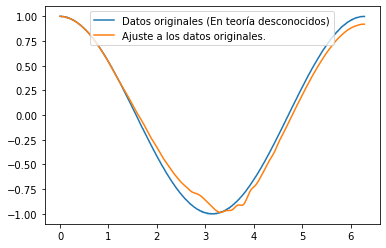

In [91]:
def F_ajuste_original(sigma,alpha,z):#Funcion de ajuste dado alpha, sigma, x. Con x real
    sum=0
    for j in range(m):
        sum+=alpha[j]*np.exp(-(1/(2*sigma[j]**2))*(z-x_m[j])**2)
    return sum
def F_ajuste_a_s_original(W):
       R=[]
       for w in W:
           R.append(F_ajuste_original(sigma=sigma_0,alpha=alpha_0,z=w))
       return np.array(R) 
plt.plot(x,y,label='Datos originales (En teoría desconocidos)')
plt.plot(x,F_ajuste_a_s_original(x)+y[0]-F_ajuste_original(sigma=sigma_0,alpha=alpha_0,z=0),label='Ajuste a los datos originales.')
plt.legend()
plt.show()